# Experiments on synthetic data

In [1]:
%load_ext autoreload

%autoreload 2

Required imports

In [2]:
import numpy as np
import pickle
import torch

from matplotlib import pyplot as plt
%matplotlib inline

from utils.train_synthetic import run_synthetic_experiments, load_synthetic_results
from utils.results import *

In [3]:
BASELINES = ['QRNN', 'DPRNN', 'CFRNN', 'AdaptiveCFRNN']

## Time-dependent noise profile

Training procedure for CF-RNN/MQ-RNN/DP-RNN baselines (for 5 different seeds):

In [6]:
for baseline in ['CFRNN', 'AdaptiveCFRNN', 'QRNN', 'DPRNN']:
    for seed in range(5):
        run_synthetic_experiments(experiment='time_dependent', 
                                  baseline=baseline,
                                  n_train = 2000,
                                  retrain_auxiliary=True,
                                  save_model=True, 
                                  save_results=True,
                                  rnn_mode='LSTM',
                                  seed=seed)

Training CFRNN
Training dataset 0
Training dataset 1
Training dataset 2
Training dataset 3
Training dataset 4
Training CFRNN
Training dataset 0
Epoch: 0	Train loss: 81.79501037597656
Epoch: 50	Train loss: 12.973886489868164
Epoch: 100	Train loss: 12.734036827087403
Epoch: 150	Train loss: 12.44111499786377
Epoch: 200	Train loss: 11.599647331237794
Epoch: 250	Train loss: 10.567817211151123
Epoch: 300	Train loss: 10.029623031616211
Epoch: 350	Train loss: 8.607649230957032
Epoch: 400	Train loss: 7.97518744468689
Epoch: 450	Train loss: 8.134216928482056
Epoch: 500	Train loss: 6.904873085021973
Epoch: 550	Train loss: 6.72160382270813
Epoch: 600	Train loss: 7.068408012390137
Epoch: 650	Train loss: 6.254941940307617
Epoch: 700	Train loss: 9.200609588623047
Epoch: 750	Train loss: 7.1578575611114506
Epoch: 800	Train loss: 6.731553030014038
Epoch: 850	Train loss: 6.427328968048096
Epoch: 900	Train loss: 8.460420894622803
Epoch: 950	Train loss: 7.296691656112671
Training dataset 1
Epoch: 0	Train l

Evaluation:

**Joint coverage**

Prints mean joint coverage across the horizon (mean±std for 5 random seeds)

In [8]:
for baseline in ['CFRNN', 'AdaptiveCFRNN', 'QRNN', 'DPRNN']:
    print(baseline)
    coverages_mean, coverages_std = get_joint_coverages(baseline, 'time_dependent', seeds=range(5))
    
    for m, s in zip(coverages_mean, coverages_std):
        print('{:.1f} \\(\\pm\\) {:.1f}\\%'.format(m, s))
    print()

CFRNN
92.7 \(\pm\) 1.3\%
92.4 \(\pm\) 0.9\%
90.9 \(\pm\) 1.3\%
90.6 \(\pm\) 1.2\%
91.1 \(\pm\) 0.7\%

AdaptiveCFRNN
92.1 \(\pm\) 1.7\%
91.5 \(\pm\) 0.7\%
91.3 \(\pm\) 1.6\%
91.1 \(\pm\) 1.9\%
91.7 \(\pm\) 1.5\%

QRNN
63.0 \(\pm\) 2.8\%
59.7 \(\pm\) 2.5\%
57.5 \(\pm\) 3.1\%
57.7 \(\pm\) 3.0\%
59.0 \(\pm\) 2.2\%

DPRNN
2.0 \(\pm\) 0.5\%
0.7 \(\pm\) 0.3\%
0.2 \(\pm\) 0.1\%
0.2 \(\pm\) 0.2\%
0.1 \(\pm\) 0.2\%



**Interval widths**

Prints the baseline; mean±std of interval width across horizons; rows denote the noise configuration and columns the random seed. 

In [9]:
for baseline in ['CFRNN', 'AdaptiveCFRNN', 'QRNN', 'DPRNN']:
    print(baseline)
    widths_mean, widths_std = get_interval_widths(baseline, 'time_dependent', seeds=[0])
    
    print(widths_mean)
    print(widths_mean.mean(axis=1))
    print()

CFRNN
[[14.49003506 17.6398468  20.45935249 22.54831314 25.33989143]
 [19.45007515 22.63418388 26.49905014 28.42730904 30.55492592]
 [25.62024307 32.90212631 32.74377823 36.74335098 40.120327  ]
 [35.80745697 37.73675919 40.80746841 42.71001434 45.3491745 ]
 [38.64740753 46.31994629 49.80871964 48.91173553 57.27165604]]
[20.09548779 25.51310883 33.62596512 40.48217468 48.19189301]

AdaptiveCFRNN
[[16.84167671 21.48139191 24.07303429 28.98034859 32.60723114]
 [22.43384743 24.74682236 33.42056656 31.4728241  40.86390686]
 [32.85133362 36.09113312 37.26663208 48.36781311 54.86948013]
 [52.25448608 44.42847824 52.44072342 55.29881668 54.37046051]
 [50.45061874 53.79924393 66.54753113 62.5015564  71.39278412]]
[24.79673653 30.58759346 41.88927841 51.75859299 60.93834686]

QRNN
[[ 8.64198971 10.85765266 12.20258999 13.20440102 13.49247837]
 [12.62475395 13.76492977 16.0915184  16.55451012 17.76583481]
 [17.40897369 19.21748161 20.16820717 21.70124054 23.37950897]
 [20.97474861 22.15851974 24

# Static noise profile

In [10]:
for baseline in ['CFRNN', 'AdaptiveCFRNN', 'QRNN', 'DPRNN']:
    for seed in range(5):
        run_synthetic_experiments(experiment='static', 
                                  baseline=baseline,
                                  n_train = 2000,
                                  retrain_auxiliary=True,
                                  save_model=True, 
                                  save_results=True,
                                  rnn_mode='LSTM',
                                  seed=seed)

Training CFRNN
Training dataset 0
Epoch: 0	Train loss: 81.24044494628906
Epoch: 50	Train loss: 9.250524425506592
Epoch: 100	Train loss: 9.006788682937621
Epoch: 150	Train loss: 8.388805389404297
Epoch: 200	Train loss: 7.657482576370239
Epoch: 250	Train loss: 7.34607081413269
Epoch: 300	Train loss: 7.26207537651062
Epoch: 350	Train loss: 6.29205093383789
Epoch: 400	Train loss: 5.312899732589722
Epoch: 450	Train loss: 5.130415296554565
Epoch: 500	Train loss: 4.849606561660766
Epoch: 550	Train loss: 5.5908119678497314
Epoch: 600	Train loss: 4.363440227508545
Epoch: 650	Train loss: 4.283811330795288
Epoch: 700	Train loss: 6.369759798049927
Epoch: 750	Train loss: 4.4529987335205075
Epoch: 800	Train loss: 4.771352291107178
Epoch: 850	Train loss: 4.807813453674316
Epoch: 900	Train loss: 4.194506573677063
Epoch: 950	Train loss: 7.1635761737823485
Training dataset 1
Epoch: 0	Train loss: 83.23585433959961
Epoch: 50	Train loss: 8.845319700241088
Epoch: 100	Train loss: 8.229940462112427
Epoch: 150

In [2]:
for baseline in ['DPRNN', 'QRNN', 'CFRNN']:
    for seed in range(1):
        run_synthetic_experiments(experiment='sample_complexity', 
                                  baseline=baseline,
                                  retrain=True,
                                  save_model=True, 
                                  save_results=True,
                                  rnn_mode='LSTM',
                                  seed=seed)

Training DPRNN
Training dataset 0
Epoch:  0 | train loss: 8.9006
Epoch:  1 | train loss: 7.9289
Epoch:  2 | train loss: 6.3755
Epoch:  3 | train loss: 6.2213
Epoch:  4 | train loss: 5.9630
Epoch:  5 | train loss: 5.4053
Epoch:  6 | train loss: 4.8384
Epoch:  7 | train loss: 4.3107
Epoch:  8 | train loss: 5.1275
Epoch:  9 | train loss: 5.0374
Training dataset 1
Epoch:  0 | train loss: 12.9976
Epoch:  1 | train loss: 9.9700
Epoch:  2 | train loss: 8.5962
Epoch:  3 | train loss: 8.9132
Epoch:  4 | train loss: 8.1799
Epoch:  5 | train loss: 6.6170
Epoch:  6 | train loss: 7.0963
Epoch:  7 | train loss: 8.9090
Epoch:  8 | train loss: 6.6403
Epoch:  9 | train loss: 7.5974
Training dataset 2
Epoch:  0 | train loss: 14.9481
Epoch:  1 | train loss: 11.5665
Epoch:  2 | train loss: 13.9324
Epoch:  3 | train loss: 12.6081
Epoch:  4 | train loss: 11.1678
Epoch:  5 | train loss: 10.3419
Epoch:  6 | train loss: 10.5155
Epoch:  7 | train loss: 10.8194
Epoch:  8 | train loss: 9.8517
Epoch:  9 | train lo

In [3]:
for baseline in ['DPRNN', 'QRNN', 'CFRNN']:
    print(baseline)
    coverages_mean, coverages_std = get_joint_coverages(baseline, 'sample_complexity', seeds=[0])
    
    for m, s in zip(coverages_mean, coverages_std):
        print('{:.1f} \\(\\pm\\) {:.1f}\\%'.format(m, s))
    print()

DPRNN
0.0 \(\pm\) 0.0\%
9.0 \(\pm\) 0.0\%
4.1 \(\pm\) 0.0\%
1.3 \(\pm\) 0.0\%
1.2 \(\pm\) 0.0\%

QRNN
0.0 \(\pm\) 0.0\%
1.0 \(\pm\) 0.0\%
55.8 \(\pm\) 0.0\%
67.5 \(\pm\) 0.0\%
69.3 \(\pm\) 0.0\%

CFRNN
60.0 \(\pm\) 0.0\%
97.0 \(\pm\) 0.0\%
92.7 \(\pm\) 0.0\%
92.9 \(\pm\) 0.0\%
92.2 \(\pm\) 0.0\%



In [5]:
for baseline in ['DPRNN', 'QRNN', 'CFRNN']:
    print(baseline)
    widths_mean, widths_std = get_interval_widths(baseline, 'sample_complexity', seeds=[0])
    
    print(widths_mean)
    print(widths_mean.mean(axis=1))
    print()

DPRNN
[[5.12453747 4.50470066 4.03281975 5.25400639 4.12917805]
 [5.96365643 5.37311411 5.05941391 5.14833879 5.16559267]
 [3.94802403 3.88020778 3.78417134 3.45748663 3.13291001]
 [2.80340242 2.4956286  2.25398254 2.00947738 1.82563126]
 [2.6179688  2.34353113 2.13293767 1.93335545 1.79784811]]
[4.60904846 5.34202318 3.64055996 2.27762444 2.16512823]

QRNN
[[ 2.6115737   2.69796181  3.76921844  6.94951248  6.11241531]
 [ 2.81715727  2.55868769  3.3852191   3.09238124  3.12100101]
 [ 8.74661922  9.61013126 11.24615383 11.71823883 12.89940739]
 [ 9.10296726 10.69437981 12.11260509 13.1353035  13.86662483]
 [ 9.28291607 11.01956367 12.07672787 13.49699497 14.41510296]]
[ 4.42813635  2.99488926 10.84411011 11.7823761  12.05826111]

CFRNN
[[ 9.71791172 11.93279743 21.81966019 30.91895676 18.60017776]
 [17.75201225 21.56806374 24.28650093 23.49391937 28.52600861]
 [14.7836132  17.7034626  21.19920731 23.05413628 24.91507149]
 [13.39372158 15.97120667 17.84673882 19.80384445 20.94856453]
 [1

In [6]:
import seaborn as sns

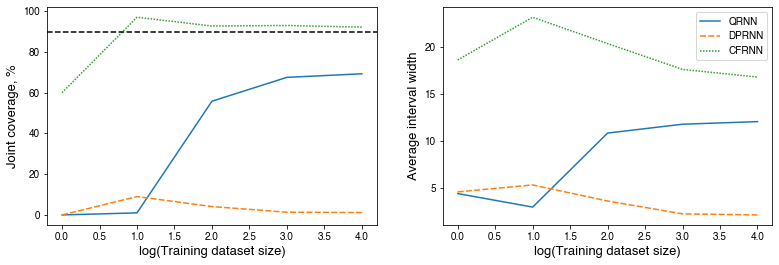

In [10]:
coverages_mean, coverages_std = {}, {}
for baseline in ['QRNN', 'DPRNN', 'CFRNN']:
    coverages_mean[baseline], coverages_std[baseline] = \
        get_joint_coverages(baseline, 'sample_complexity', seeds=[0])
    
widths_mean = {}
for baseline in ['QRNN', 'DPRNN', 'CFRNN']:
    widths_mean[baseline] = \
        get_interval_widths(baseline, 'sample_complexity', seeds=[0])[0].mean(axis=1)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13, 4))

figa = sns.lineplot(ax=ax1, data=coverages_mean, legend=None)
figa.axhline(90, linestyle="--", color="black")
figa.set(xlabel="log(Training dataset size)", ylabel="Joint coverage, %")
    
figb = sns.lineplot(ax=ax2, data=widths_mean)
figb.set(xlabel="log(Training dataset size)", ylabel="Average interval width")
plt.show()

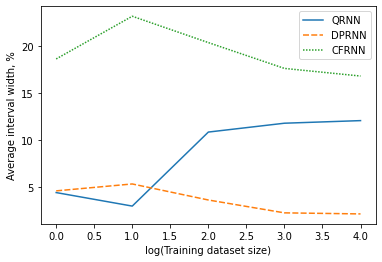

In [21]:

plt.show()

## Static noise, no periodic component (Table ?)

## Periodic component (Figure ?)

## Plotting

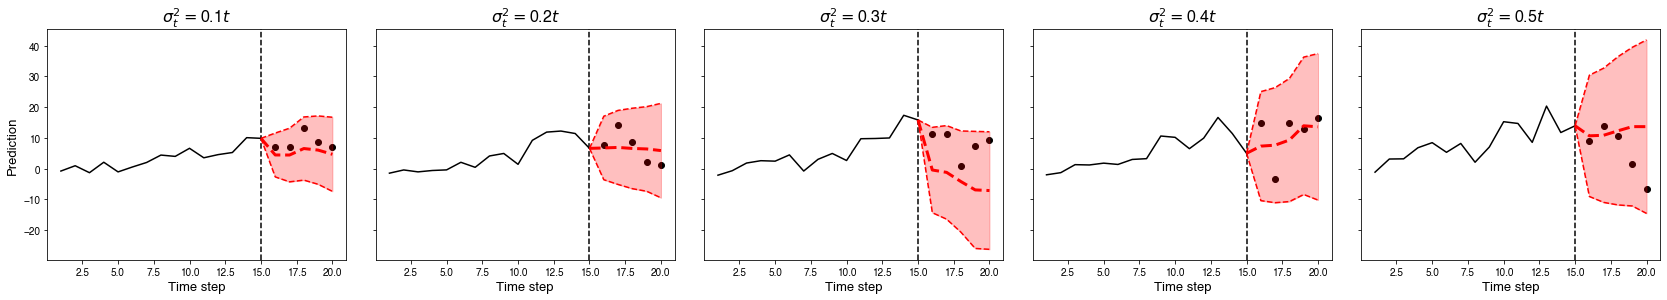

In [7]:
plot_timeseries(experiment='time_dependent', baseline='CFRNN', index=range(6,7))

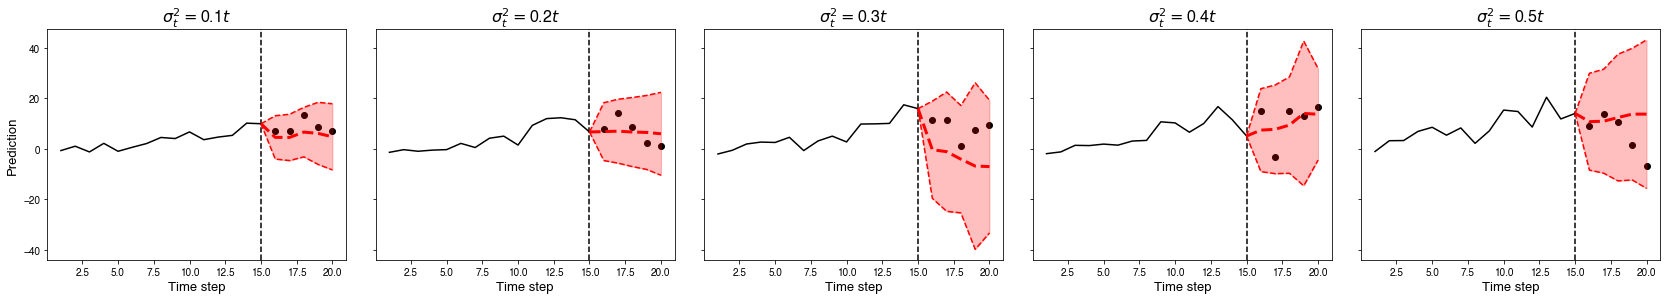

In [9]:
plot_timeseries(experiment='time_dependent', baseline='AdaptiveCFRNN', index=range(6,7))

## Long horizon analysis (Figure 4)

Training code for the three underlying RNN models:

In [ ]:
from utils.train_synthetic import run_synthetic_experiments
run_synthetic_experiments(experiment='long-horizon', retrain=True, save_model=True, save_results=False, rnn_mode='GRU')
run_synthetic_experiments(experiment='long-horizon', retrain=True, save_model=True, save_results=False, rnn_mode='RNN')
run_synthetic_experiments(experiment='long-horizon', retrain=True, save_model=True, save_results=False, rnn_mode='LSTM')

Analyzing interval widths:

In [ ]:
import torch
widths = {}
for rnn_model in ['LSTM', 'RNN', 'GRU']:
    model = torch.load('saved_models/long-horizon_CPRNN_{}_100.pt'.format(rnn_model))
    
    ws = []
    alphas = np.arange(100) * 0.01
    for alpha in alphas:
        corrected_alpha = alpha / model.horizon
        corrected_critical_calibration_scores = torch.tensor([[
                torch.quantile(
                    position_calibration_scores,
                    q=1 - corrected_alpha * model.n_train / (model.n_train + 1))
                for position_calibration_scores in feature_calibration_scores]
                for feature_calibration_scores in model.calibration_scores]).T
        ws.append(corrected_critical_calibration_scores.flatten().tolist())
    ws = np.array(ws)
    ws = ws * 2
    widths[rnn_model] = ws

In [ ]:
def compute_valid_horizons(threshold_width=15):
    valid_horizons = {}
    for rnn_model in ['LSTM', 'RNN', 'GRU']:    
        T = []
        ws = widths[rnn_model]
        for i, _ in enumerate(alphas):
            t = 0
            while t < ws.shape[1] and ws[i, t] < threshold_width:
                t += 1
            T.append(t)
        valid_horizons[rnn_model] = np.array(T)
    return valid_horizons

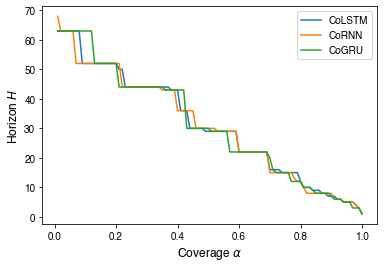

In [132]:
for threshold_width in [16]:
    valid_horizons = compute_valid_horizons(threshold_width)
    for rnn_model in valid_horizons.keys():
        plt.plot(1-alphas, valid_horizons[rnn_model], label='Co{}'.format(rnn_model))
plt.xlabel('Coverage $1-\\alpha$')
plt.ylabel('Horizon $H$')
plt.legend()
plt.savefig('{}.png'.format('tradeoff') , bbox_inches='tight', dpi=1000)
plt.show()

## BJRNN baseline

Example for training the time-dependent noise profile, for a single seed.

In [ ]:
from utils.train_synthetic import train_bjrnn
results = train_bjrnn(noise_mode='time-dependent')